Converted mat data to CSV and imported as arrays.
Inported matplotlib and scipy to create PSDs

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import wave_model as wm
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
from scipy import signal

#velocities are in m/s and the pressure is in decibars (1db = 104 Pa)
CB_data = np.loadtxt('data/ADV_data_CB_out1.csv',delimiter=',',skiprows=1)
#data order: dn,P,u,v,w
CB_data = CB_data.transpose()

MV_data = np.loadtxt('data/ADV_data_MV_out1.csv',delimiter=',',skiprows=1)
#data order: dn,P,u,v,w
MV_data = MV_data.transpose()
datatypes = ["Pressure","HorizontalU Velocity","HorizontalV Velocity","Vertical Velocity"]
#MV: water depth is 16m
#    data was collected 0.4m above the seafloor (z = -15.6m)
#CB: water depth is 14m
#    data was collected 1.8m below the mean sea surface (z = -1.8m)
# sampling frequency of the instrument is 32Hz.
# time (dn)
# pressure (P)
# horizontal velocity (u & v)
# vertical velocity (w)

1.	Compute and plot the spectrum of pressure, vertical velocity and horizontal velocity (Suu+Svv) for both locations.  Describe the differences between the locations and explain what might cause these differences:

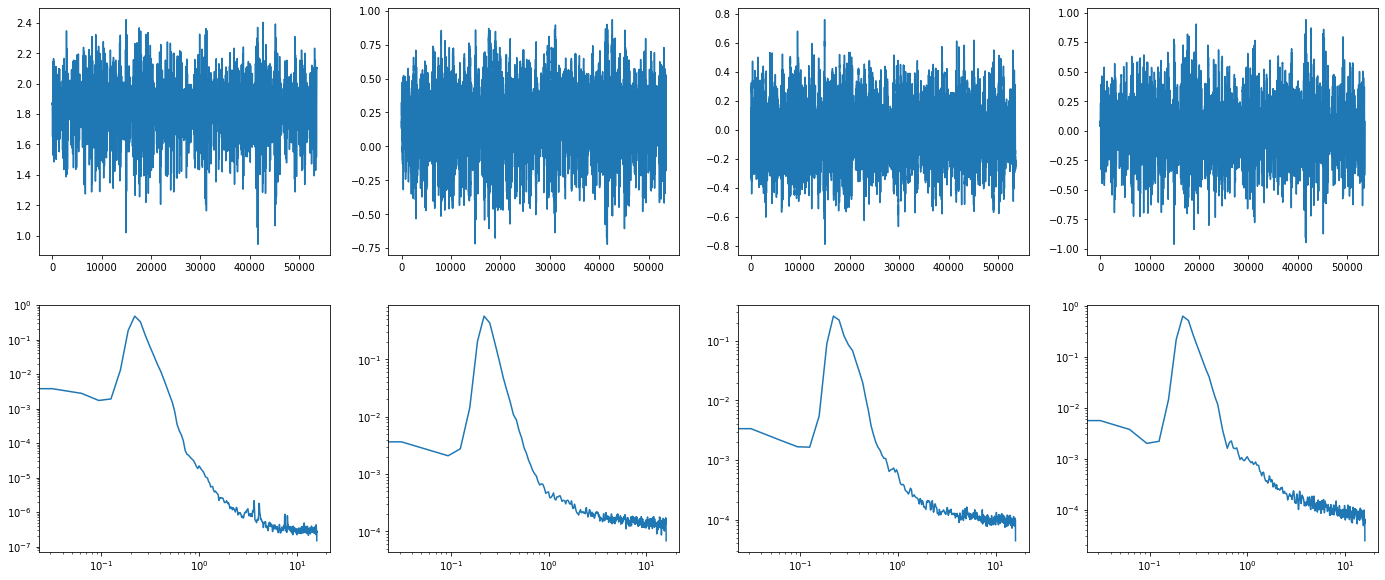

In [6]:
fig, ((ax0,ax2,ax4,ax6),(ax1,ax3,ax5,ax7)) = plt.subplots(2, 4,figsize=(24, 10))
i=0
plots = fig.get_axes()
for i in range(4):
    plots[i].plot(CB_data[i+1])
    #plots[i+4].psd(CB_data[i+1], NFFT=150, Fs=32, window=mlab.window_none, pad_to=512, noverlap=75,scale_by_freq=True)

    f, Pxx_den = signal.welch(CB_data[i+1], 32, nperseg=1024)
    plots[i+4].loglog(f, Pxx_den)

    #plots[i+4].semilogx()

"""
ax1.set_title('Welch Settings:')
ax1.set_ylabel('')  # overwrite the y-label added by `psd`
ax1.grid(True)
#ax7.set_xlim(-10, 20)
"""
plt.show()

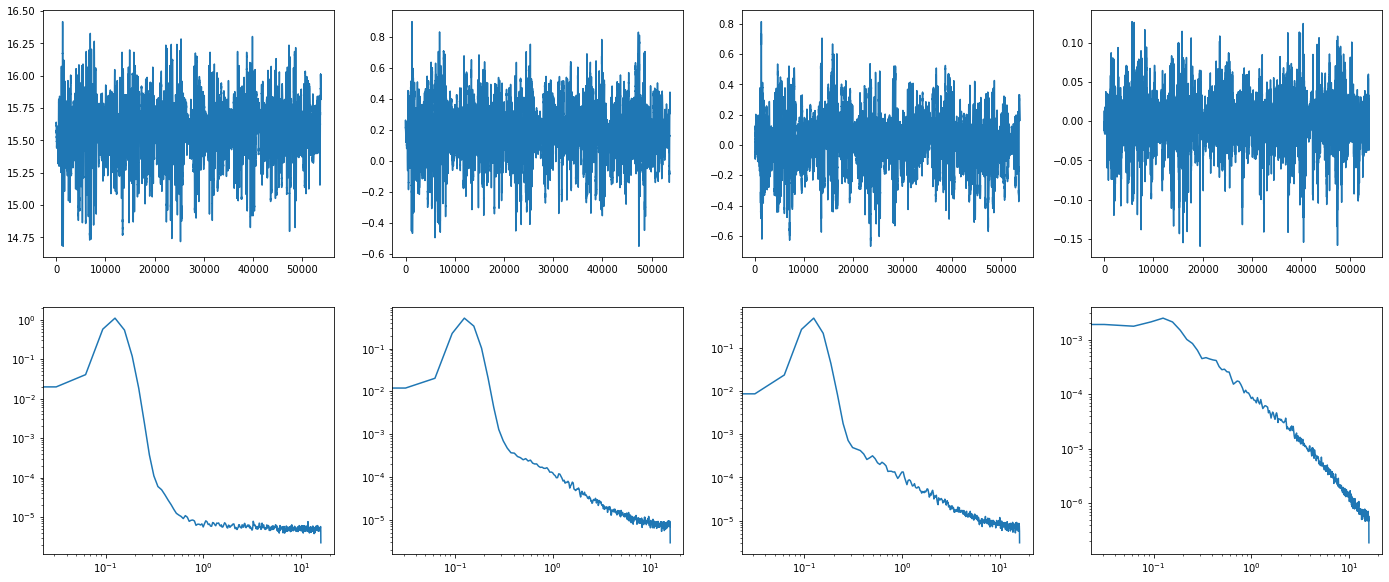

In [18]:
dt = 0.01
fig, ((ax0,ax2,ax4,ax6),(ax1,ax3,ax5,ax7)) = plt.subplots(2, 4,figsize=(24, 10))
i=0
plots = fig.get_axes()
for i in range(4):
    plots[i].plot(MV_data[i+1])
    #plots[i+4].psd(MV_data[i+1], NFFT=150, Fs=32, window=mlab.window_none, pad_to=512, noverlap=75,scale_by_freq=True)
    f, Pxx_den = signal.welch(MV_data[i+1], 32, nperseg=1024)
    plots[i+4].loglog(f, Pxx_den)


plt.show()